### Getting started with Backtrader
This is part of the KE5207 project assignment: GA-Fuzzy System for
Trading Crude Palm Oil Futures

### Setup the trading rules and platform here

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pylab as pylab
import csv

import pytz
import random
from os import listdir
from os.path import isfile, join

import skfuzzy as fuzz
from skfuzzy import control as ctrl
import math

import pdb
import operator
from __future__ import division
import numpy as np
import random,pdb
import operator

path_sep='\\'
modpath1 = os.getcwd() +path_sep+ "Data" + path_sep

In [2]:
def getFilesAndNames(dirpath):
    ''' Return only the Futures files from the directory'''
    onlyfiles = []
    for f in listdir(dirpath):
        fullpath = join(dirpath, f)
        if isfile(fullpath) and f.startswith("F"):
            onlyfiles.append((fullpath,f.split(".")[0]))
    #print (onlyfiles)
    return onlyfiles

#getFilesAndNames(os.getcwd() + "\\Data\\")

In [3]:
# setup data
def setup_multiple_data(bt, cerebro, bTestMode):
    modPath = modpath1 #os.getcwd() + "\\Data\\"
    if bTestMode:
        modPath = modPath + "Test" + path_sep
    else:
        modPath = modPath + "Prod"
    
    datalist = getFilesAndNames(modPath)
    
    for i in range(len(datalist)):
        df = pd.read_csv(datalist[i][0])
        start_test = datetime.datetime.strptime(df['DateTime'][0], "%d/%m/%Y %H:%M")
        end_test = datetime.datetime.strptime(df['DateTime'][len(df)-1], "%d/%m/%Y %H:%M")
        
        # setup the data path
        #datafile = "FCPO_6_years_NUS.xlsx"
        data = bt.feeds.GenericCSVData(
            dataname=datalist[i][0],
            fromdate= start_test,
            todate= end_test,
            nullvalue=0.0,
            dtformat=('%d/%m/%Y %H:%M'),
            tz = pytz.timezone('Asia/Jakarta'),
            datetime=2,
            high=4,
            low=5,
            open=3,
            close=6,
            volume=7#,
            #timeframe = bt.TimeFrame.Minutes
        )
        # Add the Data Feed to Cerebro
        cerebro.adddata(data, name=datalist[i][1])
        
        #print ("Added data source {}".format(datalist[i][0]))
        #if testmode:
        return 

In [4]:
def setup_platform(cerebro):
    ''' Setup the rules of engagement'''
    # Set our desired cash start, using MYR
    cerebro.broker.setcash(10000000.0)

    # Set the commission - max of 0.2% or RM30
    comminfo = CommInfo_Fut_Perc_Mult(
        commission=0.002,#,  # 0.2%
        #mult=1,
        margin = 4000
    )

    cerebro.broker.addcommissioninfo(comminfo)
    #cerebro.broker.setcommission(commission=0.001)

    
    # Add a FixedSize sizer according to the stake
    #cerebro.addsizer(bt.sizers.FixedSize, stake=1)

In [5]:
class CommInfo_Fut_Perc_Mult(bt.CommInfoBase):
    #params = (
    #  ('stocklike', False)#,  # Futures
      #('commtype', bt.CommInfoBase.COMM_PERC),  # Apply % Commission
      # ('percabs', False),  # pass perc as xx% which is the default
    #)

    def _getcommission(self, size, price, pseudoexec):
        return max(30, size * price * self.p.commission * self.p.mult)

In [6]:
def setup_plot():
    pylab.rcParams['figure.figsize'] = 45, 30  # that's default image size for this interactive session
    pylab.rcParams['font.family'] = 'sans-serif'
    pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
    pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
    pylab.rcParams["font.size"] = "200"

    #plotter = Plotter()
    #back_tester.plot(plotter=plotter)

    #plor the result
    #plt.figure(figsize=(15,20))
    #cerebro.plot(style='candlestick', iplot=False)
    #imagefile = "test_strategy.png"
    #modpath = os.getcwd() + "\\"
    ##datapath = os.path.join(modpath, imagefile)
    #pylab.savefig(datapath)


### Visualise the data
Data exploration and check the trend for the test data.

In [7]:
import os
modpath = modpath1 + "Test" + path_sep
datalist = getFilesAndNames(modpath)

df = pd.read_csv(datalist[1][0])


In [8]:
# Sort DataFrame by date
df = df.sort_values('DateTime')

# Double check the result
df.head()

,Date,Time,DateTime,Open,High,Low,Close,Volume
5963,20130701,10:30:00,01/07/2013 10:30,2147,2156,2146,2155,369
5964,20130701,10:31:00,01/07/2013 10:31,2154,2154,2151,2154,91
5965,20130701,10:32:00,01/07/2013 10:32,2155,2156,2155,2156,49
5966,20130701,10:33:00,01/07/2013 10:33,2156,2158,2156,2157,72
5967,20130701,10:34:00,01/07/2013 10:34,2157,2159,2157,2157,70


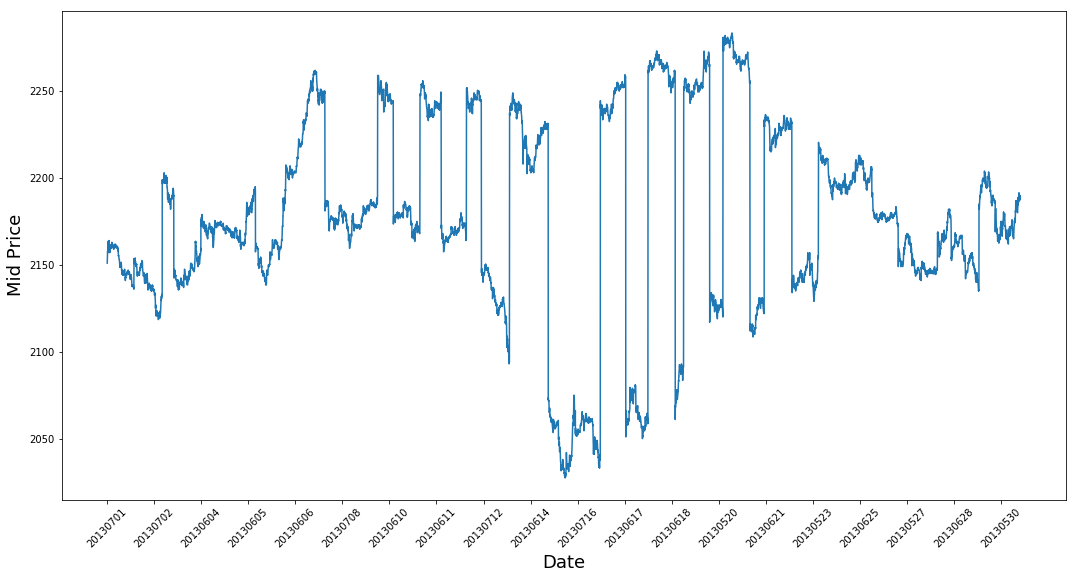

In [9]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

### Helper functions can be found here
This section contains the generic function used in this notebook.

In [10]:
# https://stackoverflow.com/questions/9489078/how-to-split-a-huge-csv-file-based-on-content-of-first-column
import csv
from itertools import groupby

def split_excel_to_csv():
    datafile = 'FCPO_6_years_NUS.csv'
    modpath = modpath1 #os.getcwd() + "\\Data\\"
    datapath = os.path.join(modpath, datafile)
    csv_header = 'Date,Time,DateTime,Open,High,Low,Close,Volume'
    reader = csv.reader(open(datapath))
    next(reader)
    for key, rows in groupby(reader,lambda row: row[0]):
        if key[-1] in ["1","2","3"]:
            outputpath = os.path.join(modpath+"Test"+path_sep,"{}.csv".format(key))
        else:
            outputpath = os.path.join(modpath+"Prod"+path_sep,"{}.csv".format(key))
        with open(outputpath, "w") as output:
            output.write(csv_header + "\n")
            for row in rows:
                row.pop(0) # remove the key
                output.write(",".join(row) + "\n")
                
#split_excel_to_csv()

In [11]:
def writeToCsv(filepath, data):
    ''' Generate a csv file which contains the seven fuzzy extent centroid value'''
    with open(filepath,'w') as f:
        #print ("max {} and min {}".format(max(data), min(data)))
        f.write(",".join(map(str,splitDataToSevenExtents(data))))
        
def loadFromCsv(filepath):
    ''' Load the previous stored fuzzy extent values from csv file'''
    with open(filepath, 'rt') as f:
        reader = csv.reader(f)
        return list(map(float,[r for r in reader][0]))

In [12]:
def splitDataToSevenExtents(data):
    ''' Split a list of array into seven parts meant for the fuzzy extent later
        Calculate the central point and also the std dev '''
    # get the max and min
    max_point = max(data)
    # split the positive into three parts
    min_point = min(data)
    # split the negative into three parts
    pos_part = 0
    if max_point > 0:
        pos_part = math.ceil(max_point / 3)
    neg_part = 0
    if min_point < 0:
        neg_part = math.floor(min_point / 3)
    
    return [neg_part * 3,
            neg_part * 2,
            neg_part,
            0,
            pos_part,
            pos_part * 2,
            pos_part * 3]

In [13]:
def generateAllCombinationsIndividual():
    ''' Use to cache the fuzzy system model'''
    inds = ['sma','ama','tma','tpma']
    m = np.array([10, 20, 50, 100, 150, 200])
    n = np.array([3,5,10,15,20])
    ext = "M"
    rec = 0
    
    rules = []
    for i in inds:
        for slow in m:
            for fast in n:
                if fast < slow:
                    rule = [i, fast, slow, ext, rec]
                    rules.append(rule)
                    
    return {"individual":np.array(rules)}

#generateAllCombinationsIndividual()

In [14]:
def generateRandomRule():
    ''' generate one random rule'''
    inds = ['sma','ama','tma','tpma']
    m = np.array([10, 20, 50, 100, 150, 200])
    n = np.array([3,5,10,15,20])
    exts = ['VL','EL','L','M','H','VH','EH']
    neg = np.arange(-1,0,0.1)
    med = np.arange(-1,1,0.1)
    pos = np.arange(0,1,0.1)

    sel_ext = random.choice(exts)
    rec = 0
    if sel_ext in ['VL','EL','L']:
        rec = random.choice(neg)
    elif sel_ext in ['M']:
        rec = random.choice(med)
    else:
        rec = random.choice(pos)
        
    fast = random.choice(n)
    slow = random.choice(m[m>fast])

    return [random.choice(inds), fast, slow, sel_ext, rec]
    
#print (generateRandomRule())

def generateRandomIndividual():
    rules = []
    total_rules = 10
    for i in range(0,total_rules):
        rules.append(generateRandomRule())
    
    return {"individual":np.array(rules)}

#print (generateRandomIndividual())

def generateRandomPopulation(size=20):
    population = dict()
    for i in range(0,size):
        population[i] = generateRandomIndividual()
    return population

#def modifyIndividual(ind):
#    ind["newkey"] = 0

#pop= generateRandomPopulation()

#modifyIndividual(pop[1])

#print (pop[1])
#for ind in pop.items():
#    print (ind)
#for rule in pop[1]["individual"]:
#    print (rule)
#pop[1]["rating"] = 10

#population = {0:{"ind":[]}}
#population[0]['ind'] = {}

### Building the fuzzy extents
Use the old data output the values to an external file to that the fuzzy extents models can be build later.

In [15]:
def buildFuzzySystem(arr, bShowPlot=False, bDebug=False):
    '''Given an array of value, build and return a fuzzy system'''
    # New Antecedent/Consequent objects hold universe variables and membership functions

    feModel = ctrl.Antecedent(np.arange(arr[0], arr[-1], 0.1), 'feModel')
    recModel = ctrl.Consequent(np.arange(-1, 1, 0.1), 'recModel')

    recModel["Neg"] = fuzz.pimf(recModel.universe, -1, -1, -1, 0)
    recModel["Med"] = fuzz.pimf(recModel.universe, -1, 0, 0, 1)
    recModel["Pos"] = fuzz.pimf(recModel.universe, 0, 1, 1, 1)
    
    feModel["EL"] = fuzz.pimf(feModel.universe, arr[0], arr[0], arr[0],arr[1])
    feModel["VL"] = fuzz.pimf(feModel.universe, arr[0], arr[1], arr[1], arr[2])
    feModel["L"] = fuzz.pimf(feModel.universe, arr[1], arr[2], arr[2], arr[3])
    feModel["M"] = fuzz.pimf(feModel.universe, arr[2], arr[3], arr[3], arr[4])
    feModel["H"] = fuzz.pimf(feModel.universe, arr[3], arr[4], arr[4], arr[5])
    feModel["VH"] = fuzz.pimf(feModel.universe, arr[4], arr[5], arr[5], arr[6])
    feModel["EH"] = fuzz.pimf(feModel.universe, arr[5], arr[6], arr[6], arr[6])

    if bShowPlot:
        recModel.view()
        feModel.view()
    
    if bDebug:
        print (type(recModel))
        print (type(feModel))

    #build the rules
    rule1 = ctrl.Rule(feModel["EL"] | feModel["L"] | feModel["VL"], recModel["Neg"])
    rule2 = ctrl.Rule(feModel["M"], recModel["Med"])
    rule3 = ctrl.Rule(feModel["EH"] | feModel["H"] | feModel["VH"], recModel["Pos"])
    
    ctrl_sys = ctrl.ControlSystem([rule1, rule2, rule3])
    ctrl_instance = ctrl.ControlSystemSimulation(ctrl_sys)
    
    return ctrl_instance, feModel, recModel

In [16]:
def getFuzzyOutput(ctrl_instance, feModel, recModel, input_val, bShowPlot=False, bDebug=False):
    ''' Given the fuzzy system and the input value, compute and return the mf and the fuzzy extent'''

    ext = ""
    rec = 0
    ants = []
    try:
        ctrl_instance.input['feModel'] = input_val
        ctrl_instance.compute()

        if bShowPlot:
            recModel.view(sim=ctrl_instance)
            feModel.view(sim=ctrl_instance)
    
        ants = ctrl_instance.get_antecedents()
        
        if bDebug:
            print (type(recModel))
            print (type(feModel))
            #print (ctrl_instance.print_state())
 
        ext = ""
        if ants:
            ext = max(ants, key=ants.get)
            rec = ctrl_instance.output['recModel']
    except:
        print("Input val:{}. fe:{}, rec:{}, ctrl:{}".format(input_val, feModel, recModel,type(ctrl_instance)))
        print ("Type ants:{} and content:{}".format(type(ants), ants))
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print("Exception type:{}, File name:{} and line no:{}".format(exc_type, fname, exc_tb.tb_lineno))
        #TODO: Handle this error properly
        raise
    
    return (rec, ext)

[-30.0, -20.0, -10.0, 0.0, 9.0, 18.0, 27.0]
<class 'skfuzzy.control.antecedent_consequent.Consequent'>
<class 'skfuzzy.control.antecedent_consequent.Antecedent'>
<class 'skfuzzy.control.antecedent_consequent.Consequent'>
<class 'skfuzzy.control.antecedent_consequent.Antecedent'>


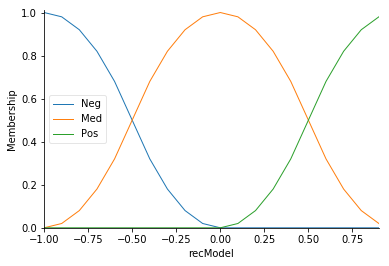

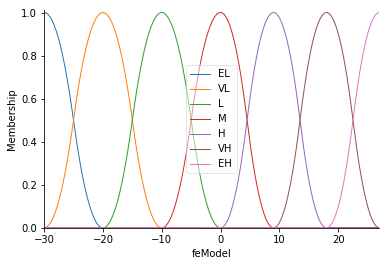

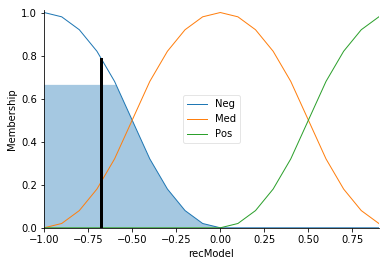

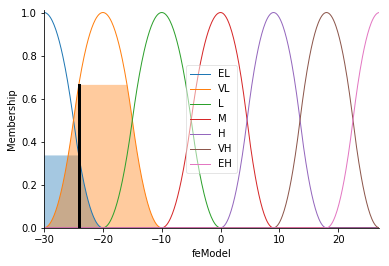

In [17]:
def testFuzzyLogic():
    #Input val:-1.6666666666669698. fe:Antecedent: fe, rec:0
    bShowPlot= True
    bDebug = True
    diffval = -24.0992834873864
    ind_type = "tpma"
    fast = "15"
    slow = "50"
    modpath = modpath1 #os.getcwd() + "\\Data\\"
    filename = "{}_{}_{}.csv".format(ind_type, fast, slow)
    filepath = os.path.join(modpath +"Model"+path_sep, filename)    
    farr = loadFromCsv(filepath) 
    print (farr)
    fuzsys, fe, rec = buildFuzzySystem(farr, bShowPlot=bShowPlot, bDebug=bDebug)
    mf, ext = getFuzzyOutput(fuzsys, fe, rec, diffval, bShowPlot=bShowPlot, bDebug= bDebug)
    
testFuzzyLogic()


### Setting up Custom indicators
Besides the standard simple moving average, we also need to setup:
1. Adaptive moving average
1. Typical Price moving average
1. Triangular moving average

In [18]:
class TypicalPriceMovingAverage(bt.Indicator):
    lines = ('tpma',)
    params = (('period', 20),)

    def __init__(self):
        self.addminperiod(self.params.period)

    def next(self):
        dataline = self.data.get(size=self.p.period)
        datasum = max(dataline) + min(dataline) + dataline[-1]
        self.lines.tpma[0] = datasum/3

### Defining strategies here
Creating a custom strategy to implement the FMAS crossover strategy.

In [19]:
class FMASCrossOver(bt.Strategy):
    """A simple moving average crossover strategy; crossing of a fast and slow moving average generates buy/sell
       signals"""
    params = {"individual":[],
              "filePath": "",
              "bSilentMode":False, #no logging
              "bDebug":False, #debug printout mode
              "bFuzzyPlot": False, #show fuzzy plot
              "bGenMaDiffFiles": False, #generate ma diff files for fuzzy extent building
              "bGetRating": False} #get overall rating for individual
    
    def calcRateOfReturn(self, value, cash, capital):
        ''' used available cash against the treasury interests'''
        '''http://www.bnm.gov.my/index.php?tpl=2014_govtsecuritiesyield'''
        ''' assume the trading period is for the whole of the short term interest'''
        shortTermBillInterests = 0.0328
        return ((value + (cash * shortTermBillInterests))/capital)
    
    def getWritePath(self, ind_type, fast, slow):
        modpath = modpath1 #os.getcwd() + "\\Data\\"
        filename = "{}_{}_{}.csv".format(ind_type, fast, slow)
        filepath = os.path.join(modpath +"Model" +path_sep, filename)
        return filepath
        
    def getFuzzyModel(self, ind_type, fast, slow, bShowPlot = False):
        filepath = self.getWritePath(ind_type, fast, slow)        
        farr = loadFromCsv(filepath)       
        fuzsys, fe, rec = buildFuzzySystem(farr, bShowPlot=bShowPlot)
        return fuzsys, fe, rec

    def getFuzzyPosition(self, fuzsys, fe, rec, diffval, bShowPlot = False):
        mf, ext = getFuzzyOutput(fuzsys, fe, rec, diffval, bShowPlot=bShowPlot)
        return mf, ext
    
    def getLotSize(self, modal, price, rating):
        return (modal/price)*rating/100
    
    def setIndicator(self, ma_type, period_val, ind_type, d):
        plottitle = "SlowMA: "
        #period_val = self.params.slow
        #ind_type = self.p.ind
        if ma_type == "fast":
            plottitle = "FastMA: "
         #   period_val = self.params.fast
            
        datafeed = self.getdatabyname(d)
        
        if self.p.bDebug:
            print ("ind:{}, ma type:{}, period:{}".format(ind_type, ma_type, period_val))
        
        ma = None
        if ind_type == 'sma':
            ma = bt.indicators.SMA(datafeed,      # The symbol for the moving average
                                   period=period_val,    # Fast moving average
                                   plotname=plottitle + d)

        elif ind_type == "ama":
            #ma = bt.indicators.KAMA(datafeed,      # The symbol for the moving average
            #                        period=period_val,    # Fast moving average
            #                        plotname=plottitle + d)
            ma = bt.talib.KAMA(datafeed, timeperiod=period_val, 
                               plotname=plottitle + d)


        elif ind_type == "tma":
            ma = bt.talib.TRIMA(datafeed,      # The symbol for the moving average
                               timeperiod=period_val,    # Fast moving average
                               plotname=plottitle + d)
        elif ind_type == "tpma":
            ma = TypicalPriceMovingAverage(datafeed,      # The symbol for the moving average
                                           period=period_val,    # Fast moving average
                                           plotname=plottitle + d)
        return ma

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        if not self.p.bSilentMode:
            #TODO: Fix the datas[0] hardcoding later
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        """Initialize the strategy"""
        
        self.bStopRunning = False
        
        self.fastma = dict()
        self.slowma = dict()
        self.regime = dict()
        self.extent = dict()
        self.recommend = dict()
        
        # only use to build the fuzzy extent files
        self.madiff = dict()
        
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.initialCapital = 0
        
        self.fuzsysModel = dict()
        self.feModel = dict()
        self.recModel = dict()
 
        self._addobserver(True, bt.observers.BuySell)    # CAUTION: Abuse of the method, I will change this in future code (see: https://community.backtrader.com/topic/473/plotting-just-the-account-s-value/4)
 
        for d in self.getdatanames():
 
            key = ""
            for rule in self.p.individual["individual"]:
                indtype = rule[0]
                fast = rule[1]
                slow = rule[2]
                extent = rule[3]
                recommend = rule[4]
                # The moving averages
                key = "{}_{}_{}_{}".format(d,indtype,fast,slow)
                self.fastma[key] = self.setIndicator("fast",int(fast), indtype,d)
                self.slowma[key] = self.setIndicator("slow",int(slow), indtype,d)
                self.madiff[key] = []
                #ma_type, period_val, ind_type, d
                
                # Get the regime
                self.regime[key] = self.fastma[key] - self.slowma[key]    # Positive when bullish
                self.extent[key] = extent
                self.recommend[key] = float(recommend)               
                self.fuzsysModel[key], self.feModel[key], self.recModel[key] \
                    = self.getFuzzyModel(indtype,fast,slow, bShowPlot=self.p.bFuzzyPlot)
            
    def next(self):
        #skip the rest of the data after we can get the rating
        if self.bStopRunning:
            return
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        
        if self.initialCapital == 0:
            self.initialCapital = self.stats.broker.cash[0]
        
        #Loop through each data feed
        for i, d in enumerate(self.datas):
            dt, dn = self.datetime.date(), d._name
            pos = self.getposition(d).size
            
            key = ""
            ratings = []
            #loop through each rules within this individual
            for rule in self.p.individual["individual"]:
                key = "{}_{}_{}_{}".format(dn,rule[0],rule[1],rule[2])
            
                # for generate ma diff files, we want to collect all the ma diff for a particular key
                if self.p.bGenMaDiffFiles:
                    self.madiff[key].append(self.regime[key][0])
                    #self.log("Regime: {}".format(self.regime[dn][0]))                 
                else:
                    try:
                        mf,ext = self.getFuzzyPosition(self.fuzsysModel[key], self.feModel[key], self.recModel[key], 
                                                       self.regime[key][0], bShowPlot=self.p.bFuzzyPlot)
                        # get the fe and recommended value based on past data
                        # check if the fe are the same 
                        rating = 0
                        if(ext == self.extent[key]):
                            # if it is then calculate the overall rating per rule
                            rating = mf * self.recommend[key]
                            ratings.append(rating)
                            if self.p.bDebug:
                                print ("Rating:{} and extent:{} for key:{}".format(rating,ext, key))
                    except:
                        print ("Key:{}".format(key))
                                
            #calculate the rating at individual level
            avg_rating = np.average(ratings)
            if not math.isnan(avg_rating) and self.p.bDebug:
                print ("Average rating:{} and pos is:{} for key:{}".format(avg_rating, pos, key))


            # for bGetRating mode, we just want to get the rating for the individual and exit
            if (avg_rating > 0 or avg_rating < 0): # and self.p.bGetRating:
                self.p.individual["rating"] = avg_rating
            #    print ("EXITING THE PROGRAM")
            #    self.bStopRunning = True
            #else:
                if avg_rating > 0:    # A buy signal
                    # BUY, BUY, BUY!!! (with default parameters)
                    self.log('%s BUY CREATE, %.2f with volume %.2f' % (dn, d.high[0], d.volume[0]), 
                             dt=d.datetime.date(0))

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.buy(data=d, price=d.high[0], 
                                          size = self.getLotSize(self.initialCapital,d.high[0],avg_rating))
                #No trade when avg_rating is 0
                elif avg_rating < 0:    # A sell signal
                        # SELL, SELL, SELL!!! (with all possible default parameters)
                        self.log('%s SELL CREATE, %.2f with volume %.2f' % (dn, d.low[0], d.volume[0]), 
                                 dt=d.datetime.date(0))

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.sell(data=d, price=d.low[0], 
                                               size = self.getLotSize(self.initialCapital,d.low[0],avg_rating))

                    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Size: %.2f, Price: %.2f, Cost: %.2f, Comm %.2f, Portfolio Value: %.2f, Cash: %.2f' %
                    (order.executed.size,
                     order.executed.price,
                     order.executed.value,
                     order.executed.comm,
                     self.stats.broker.value[0],
                     self.stats.broker.cash[0]))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            elif order.issell():
                self.log('SELL EXECUTED, Size: %.2f, Price: %.2f, Cost: %.2f, Comm %.2f, Portfolio Value: %.2f, Cash: %.2f' %
                         (order.executed.size,
                          order.executed.price,
                          order.executed.value,
                          order.executed.comm,
                         self.stats.broker.value[0],
                         self.stats.broker.cash[0]))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
    
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
    def stop(self):
        #if self.p.bGetRating:
        #    return
        
        if self.p.bGenMaDiffFiles:
            for i, d in enumerate(self.datas):
                dt, dn = self.datetime.date(), d._name

                key = ""
                #loop through each rules within this individual
                for rule in self.p.individual["individual"]:
                    key = "{}_{}_{}_{}".format(dn,rule[0],rule[1],rule[2])

                    writePath = self.getWritePath(rule[0],rule[1],rule[2])
                    writeToCsv(writePath, self.madiff[key])
                    #self.log(len(self.madiff_arr))
            return
        
        # else get the cash for a normal trade
        if "rating" not in self.p.individual.keys():
            self.p.individual['rating'] = 0
        # add the final profit value to the individual
        self.p.individual['profit'] = self.stats.broker.value[0]
        self.p.individual['ror'] = self.calcRateOfReturn(self.stats.broker.value[0],
                                                            self.stats.broker.cash[0], self.initialCapital)
        
        

### Main function goes here
We'll process one individual per run.

In [20]:
#from report import Cerebro

#if __name__ == '__main__':
def main(individual, bGetRating= False, plotFileName = "", bDebug=False, 
         bFuzzyPlot=False, bSilentMode=False,bGenMaDiffFiles=False, bTestMode=True):
    # Create a cerebro entity
    cerebro = bt.Cerebro()
    
    # get path
    modpath = modpath1 #os.getcwd() + "\\Data\\"
    #filename = "{}_{}_{}.csv".format(ind_type, fast, slow)
    #filepath = os.path.join(modpath +"\\Model\\", filename)
    
    # Add a strategy
    cerebro.addstrategy(FMASCrossOver, individual=individual, bGetRating=bGetRating,bDebug=bDebug,
                        bFuzzyPlot=bFuzzyPlot,bSilentMode=bSilentMode,bGenMaDiffFiles=bGenMaDiffFiles)

    # Create a Data Feed
    setup_multiple_data(bt, cerebro, bTestMode)

    setup_platform(cerebro)

    # Print out the starting conditions
    if not bSilentMode:
        print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Plot the result
    if not plotFileName == "":
        imagefile = "graph{}.png".format(plotFileName)
        datapath = os.path.join(modpath+"Graph"+path_sep, imagefile)
        cerebro.plot(style='candlestick', iplot=False, ytight=True, subplot=False, path=datapath)

### Strategy starts here
1. Generate the initial population. Randomly generate 20 individuals. Each individual contains 10 rules in accordance with the rules set.
1. Calculate the fuzzy moving averages in the training period. Calculate the differences between two moving averages in the training period and the previous training period using the moving average method and the length of two moving averages that the rule provides. 
1. Next, obtain the membership function according to the moving average differences of the previous training period. 
1. Calculate the rating level according to the moving average differences of this training period, the membership function, and the recommend values that the individual provides. Because every individual provides a set of recommend values, there are ultimately 20 sets of rating levels.

In [ ]:
#generate an individual that has all the combinations for indicator type, fast and slow
# Build and cache all the fuzzy models
ind = generateAllCombinationsIndividual()
main(ind, bSilentMode=True,bGenMaDiffFiles=True)

In [ ]:
inds = ['tma']
m= [20]
n = [10] #[3,5,10,15,20] #skip 1

pop= generateRandomPopulation()
#for individual in pop.items():
    #individual = np.append(individual,["ST"])
#    print (individual)

pind = {'individual': [['ama', '10', '150', 'VH', '0.1'],
       ['ama', '5', '200', 'EH', '0.5'],
       ['ama', '3', '10', 'EH', '0.7000000000000001'],
       ['tma', '3', '50', 'VH', '0.2'],
       ['tma', '15', '200', 'VL', '-0.5000000000000001'],
       ['tpma', '15', '200', 'VL', '-0.5000000000000001'],
       ['tma', '15', '150', 'EH', '0.4'],
       ['ama', '3', '20', 'M', '0.19999999999999973'],
       ['sma', '3', '100', 'VH', '0.1'],
       ['tpma', '15', '50', 'VL', '-0.40000000000000013']]}
#build the fuzzy model on the first run
#main(pind, bSilentMode=True,bGenMaDiffFiles=True)
#main(pind, bSilentMode=True, bDebug=False)
#print (pind)
#print (pop[1])
i = 1
runName = ""
for ind in pop.values():
    #print (ind)
    print ("Starting run: {}".format(i))
    main(ind, bSilentMode=True)
    i = i+1
    
#print(params[:,0],params[:,1], params[:,2], params[:,3], params[:,4])
#main(params[:,0],params[:,1], params[:,2], params[:,3], params[:,4])
#main(pop[1], bBestIndv=True)

5. Select the best individual in the training period. Calculate the trading volume using the initial capital and the rating degree. Then, calculate the rate of return according to the rate of return calculation method provided above. Every individual has a rate of return. The one that has the highest rate of return is the best individual in the training period.
1. Calculate the rate of return in the selection period using the best individual in the training period. Calculate the differences between the two moving averages of this selection period and the previous selection period. Then, obtain the membership function and calculate the rating level and the rate of return.
1. Mark the best individual. In the first cycle, mark the rate of return as the best rate of return and the best individual in the training period as the overall best individual. From the second cycle, compare the rate of return in this loop and the best rate of return. If the rate of return from this loop is higher than the best individual in the last loop, and the gap is over 0.05, replace the best rate of return and the overall best individual.

In [ ]:
def printPopulation(pop):
    #Display the population after the ror has been added
    i = 1
    runName = ""
    for ind in pop.values():
        #print (ind)
        print ("Individiual with rating:{}, profit:{}, ror:{}".format(ind["rating"], ind["profit"], ind["ror"]))    


printPopulation(pop)
        
def getBestIndividual(pop):
    ''' Given a population return the best individual based on ror'''
    # Show the best individual
    listOfKeys = [key  for (key, value) in pop.items() if value['ror'] == max(d['ror'] for d in pop.values())]
    #print (listOfKeys)
    bestIndividual = pop[listOfKeys[0]]
    return bestIndividual

# Print the best individual
print ("Best individual is:\n{}".format(getBestIndividual(pop)))

1. Conduct a population evolution. Use genetic algorithms to choose 10% of the individuals from the old population in terms of their rate of return. Next, choose 80% of the individuals from the old population together with 10% randomly generated new individuals to experience the crossover and mutation. Finally, these two parts combined to form the new population.
1. Repeat Steps (4)–(6) for 50 repetitions. 
1. Calculate the rate of return of the best individual in the test period using the overall best individual selected in the previous steps. Calculate the two moving averages in this test period and the previous test period. Then, obtain the membership function and calculate the rating level and the rate of return.
1. Move forward to the next experiment period and return to step (1).

1. After one experiment of one generation, the population needs to evolve. We take the rate of return as the fitness value and use Roulette Wheel Selection (RWS) to choose 10% of the 20 individuals from the old population. 
1. They are most likely the two best individuals. We retain the two individuals as the first part of the new population. The second part of the new population is two individuals that are randomly generated. Then we continue use RWS to select 80% of the 20 individuals from the old population which is mostly like the 16 best individuals. These 16 individuals need to go through crossover and mutation to become the third part of the new population.

# GA START

In [21]:
def convert_dict(dictPop):
    dictList= []
    for key, value in dictPop.items():
        aKey = key
        aValue = value
        #temp.append(aKey)
        #temp.append(aValue)
        dictList.append(dictPop[aKey]['individual']) 
        aKey = ""
        aValue = ""
    return dictList

In [22]:
def convertList(listPop):
    dictpop= dict()
    for i in range(len(listPop)):
        dictpop[i] = {"individual":listPop[i]}
    return dictpop

In [23]:
def select_pool(nPop,valRand=random.random()):
    ranks = dict()
    sum_rank =0
    
    for indx in range(nPop.shape[0]):
        sum_rank = 0 
        tot_cnt = 0
        for inner in range(nPop.shape[1]):
            if len(nPop[indx][inner][4]) > 0:
                sum_rank = sum_rank + abs(float(nPop[indx][inner][4]))
                tot_cnt = tot_cnt + 1
        sum_rank = sum_rank / tot_cnt
        ranks[sum_rank] = nPop[indx]
    sorted_indexed_weights = sorted(enumerate(ranks), key=operator.itemgetter(1));
    indices, sorted_weights = zip(*sorted_indexed_weights);
    tot_sum=sum(sorted_weights)
    prob = [x/tot_sum for x in sorted_weights]
    cum_prob=np.cumsum(prob)
    random_num=valRand #random.random()
    #print(random_num)
    for index_value, cum_prob_value in zip(indices,cum_prob):
        #print ('cum vlaue',cum_prob_value)
        if random_num < cum_prob_value:
            #random_num = 0
            #return index_value
            #ret_val = random.randint(index_value,len(indices)-1)
            return indices[index_value:] #,indices[ret_val]

In [24]:
def selectCrossover(pop,valueCheck):
    dictpop= dict()
    for i in range(len(pop)):
        dictpop[i] = {i:random.random()}
    listItemSel = []
    for key,value in sorted(dictpop.items()):
        if value[key] < valueCheck:
            listItemSel.append(key)
    return listItemSel

In [25]:
def crossover_pop(pop,offspring_size):
    parents = pop
    offspring = pop # creating empty list / array -- need to check 
    #print(offspring.shape)
    # The point at which crossover takes place between two parents. Usually it is at the center.
    #crossover_point = np.uint8(offspring_size[1] * 0.7)
    #rowIndex = select_pool(parents,0.7)
    #crossover_point = random.randint(0,offspring_size[1]/2)
    rowindex = selectCrossover(parents,0.7)
    selInd=0
    newRec = 0
    for k in range(int(len(rowindex)/2)):
        if selInd+1 < len(rowindex)-1:
            crossover_point = random.randint(offspring_size[1]/2,offspring_size[1]-1)
            parent1_idx = int(rowindex[selInd])
            parent2_idx = int(rowindex[selInd+1])
            #print(offspring[parent1_idx])
            offspring[parent1_idx,crossover_point:] = parents[parent2_idx,crossover_point:]
            offspring[parent2_idx,crossover_point:] = parents[parent1_idx, crossover_point:]
        selInd = selInd+2
    '''
    newRec=0
    for k in range(len(rowIndex)):
        crossover_point = random.randint(0,offspring_size[1]/2)
        parent1_idx = random.randint(0,k)
        parent2_idx = random.randint(0,k)
        offspring[newRec,0:crossover_point] = parents[parent1_idx,0:crossover_point]
        offspring[newRec,crossover_point:] = parents[parent2_idx, crossover_point:]
        newRec = newRec + 1
        offspring[newRec,0:crossover_point] = parents[parent2_idx,0:crossover_point]
        offspring[newRec,crossover_point:] = parents[parent1_idx, crossover_point:]
        newRec = newRec + 1
    for rpop in range(len(parents)):
        if rpop not in rowIndex and newRec < len(parents):
            offspring[newRec] = parents[rpop]
            newRec = newRec + 1
        if newRec >= len(parents):
            break
    '''
    return offspring

In [26]:
def mutation(offspring_gen):
    offspring = offspring_gen
    rowIndex = selectCrossover(offspring,0.01)
    selInd=0
    newRec = 0
    #rowIndex = select_pool(offspring,0.1)
    for idx in rowIndex:
        #for idx_m in range(random.randint(0,3)):
        #parent_idx = random.randint(0,19)
        rule_idx = random.randint(0,9)
        offspring[idx,rule_idx] = generateRandomRule()
    return offspring

In [27]:
def select_mating_pool(new_population,offspringSize):
    offspring = []
    rowIndex = 0
    '''
    for indx in range(20):
        rate_of_return = 0 
        cmp_ror = 0
        tot_cnt = 0 
        for inner in range(0,9):
            #print('index',indx)
            #print('inner',inner)
            if len(new_population[indx][inner][4]) > 0:
                rate_of_return=float(new_population[indx][inner][4])+rate_of_return
                tot_cnt = tot_cnt +1

        rate_of_return = float(rate_of_return/tot_cnt)


        #if rate_of_return > cmp_ror:
            #offspring.append(new_population[indx])
        ror = [indx,rate_of_return]
        if len(offspring) == 0:
            offspring.append(ror)
            offspring.append(ror)
        elif ror[1] > offspring[0][1]:
            offspring[0] = ror
        elif offspring[0][1] > ror[1] > offspring[1][1]:
            offspring[1] = ror
        #offspring.append(ror)
        #cmp_ror = rate_of_return
        #print(indx)
        #print(rate_of_return,' Rate of return ')
    '''
    #import heapq
    #heapq.nlargest(2,offspring)
    new_population1 = []
    #new_population1.append(new_population[rowIndex])
    #num_parents = 20
    #new_population1 = numpy.empty((num_parents, pop.shape[1]))
    new_population2 = list(new_population[:int(0.8 * len(new_population))])
    new_population3 = list(crossover_pop(np.array(new_population2),offspringSize))
    new_population1 = list(mutation(np.array(new_population3)))
    rowIndex = select_pool(new_population)
    new_population1.append(new_population[rowIndex[random.randint(0,len(rowIndex)-1)]])
    #rowIndex = select_pool(new_population)
    new_population1.append(new_population[rowIndex[random.randint(0,len(rowIndex)-1)]])
    for idx in range(len(offspring)):
        new_population1.append(new_population[offspring[idx][0]])
    new_population1.append(generateRandomIndividual()['individual'])
    new_population1.append(generateRandomIndividual()['individual'])
    return new_population1

In [28]:
def gaPopGeneration(npopulation):
#new_population1 = bt2.generateRandomPopulation()
    new_population = []
    new_population = np.array(convert_dict(npopulation))
    #import numpy as np
    sol_per_pop = 20  ## 10 individuals makes one population
    num_weights = 10  ## One individual contains 10 rules
    num_param_rule = 5
    pop_size = (sol_per_pop,num_weights,num_param_rule)
    offspring_size = pop_size
    
    new_population_gen = select_mating_pool(new_population,offspring_size)
    #return new_population_gen
    final_population = np.array(new_population_gen)
    #offspring_pop = crossover_pop(new_population_gen,offspring_size)
    #final_population = mutation(offspring_pop)
    #final_population1 = convertList(final_population)
    return convertList(final_population)

In [29]:
pop1= generateRandomPopulation()
newPop = gaPopGeneration(pop1)

In [30]:
print (newPop)

{0: {'individual': array([['tma', '15', '200', 'VL', '-1.0'],
       ['sma', '20', '150', 'EH', '0.2'],
       ['tma', '3', '10', 'H', '0.30000000000000004'],
       ['tpma', '3', '20', 'L', '-0.5000000000000001'],
       ['tma', '15', '20', 'M', '0.19999999999999973'],
       ['tpma', '15', '150', 'VH', '0.9'],
       ['ama', '20', '100', 'VH', '0.1'],
       ['ama', '20', '150', 'VH', '0.30000000000000004'],
       ['tpma', '20', '200', 'L', '-0.5000000000000001'],
       ['ama', '3', '200', 'L', '-1.0']], dtype='<U22')}, 1: {'individual': array([['sma', '20', '100', 'VL', '-0.8'],
       ['tpma', '10', '100', 'L', '-0.30000000000000016'],
       ['tpma', '15', '200', 'M', '0.19999999999999973'],
       ['sma', '3', '200', 'L', '-0.30000000000000016'],
       ['sma', '15', '150', 'VH', '0.5'],
       ['tma', '3', '10', 'L', '-0.30000000000000016'],
       ['ama', '20', '100', 'VH', '0.1'],
       ['ama', '20', '150', 'VH', '0.30000000000000004'],
       ['tpma', '20', '200', 'L', '-0

In [ ]:
print (newPop)

## GA END

In [ ]:
# Keep track of all population
allPop = dict()
allPop[0] = pop

numberOfTrials = 3
bestInd = getBestIndividual(pop)

training = dict()
training[0] = bestInd["ror"]
for i in range(1, numberOfTrials + 1):
    # Get a new population using ga
    newPop = gaPopGeneration(pop)
    
    j = 1
    for ind in newPop.values():
        #print (ind)
        print ("Starting run: {}".format(j))
        main(ind, bSilentMode=True)
        j = j+1

    # Store all the population
    allPop[i] = newPop
    
    #check if the new population best individual ror is more than 0.05 / 5% than the previous population.
    # If is it then replace the population and use that to start the next round
    gap = 0.05
    bestNewInd = getBestIndividual(newPop)
    training[i] = bestNewInd["ror"]
    if bestNewInd["ror"] - bestInd["ror"] >= gap:
        pop = newPop
        bestInd = bestNewInd


The crossover here indicates the exchange rules between two individuals. The crossover probability is 0.7, which is the most commonly used. We choose two individuals with a 0.7 probability and randomly generate a spot in the individuals.

Check the convergion plot.

In [ ]:
plt.plot(training.keys(), training.values())
plt.show()

### Actual trading starts here 
Using the best population, we can now run it against the new data to check the result

In [ ]:
finalBestInd = getBestIndividual(pop)
print (finalBestInd)
main(finalBestInd, bSilentMode=False, bTestMode=False)